In [1]:
import os
import warnings
from IPython.display import display, HTML
import platform
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time
import random
from PreprocessFcns import *
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [3]:
# get all data and remove useless rows
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]

Xtrain = Xtrain.reset_index(drop= True)
for index, row in Xtrain.iterrows():
    if (row['Visit'] == '4 Weeks'):
        #print(row['Visit'])
        #print(Xtrain.loc[index, 'Visit'])
        #print(index)
        Xtrain.loc[index, 'Visit'] = '1 Month'
counter = 0
subjects = Xtrain['Subject'].unique()
features = pd.DataFrame()
for s in subjects:
    strain = Xtrain[Xtrain['Subject'] == s]
    visits = strain['Visit'].unique()
    # print(s.__str__() + ' visits: ' + visits)
    for v in visits:
        vtrain = strain[strain['Visit'] == v]
        mds = float('Nan')
        baseline_mds = float('Nan')
        
        try: 
            mds = int(summary_info.loc[(summary_info.VisitNm == v) & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            mds = float('Nan')
        try:
            baseline_mds = int(summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            baseline_mds = float('Nan')
        if (np.isnan(mds) or np.isnan(baseline_mds)):
            #print(v + s.__str__())
            #counter += 1
            #display(vtrain)
            continue
        #display(vtrain)
        vtrain = vtrain.iloc[:, 5:-2]
        columns = vtrain.columns.values.tolist()

        cols = ['Subject', 'MDS score', 'Visit', 'baseline MDS']
        vals = [s, mds, v, baseline_mds]
        for c in columns:
            cols.append(c + " mean")
            cols.append(c + " var")
            vals.append(vtrain[c].mean())
            vals.append(vtrain[c].var())
            
        df = pd.DataFrame(data = [vals], columns = cols)
        if (not df.empty):
            counter += 1
        else:
            print(vals)
        features = features.append(df, ignore_index = True)
        

In [4]:
for index, row in features.iterrows():
    if (row['Visit'] == '1 Month'):
        features.loc[index, 'Visit'] = 2
    elif (row['Visit'] == '2 Weeks: Time 0'):
        features.loc[index, 'Visit'] = 0
    elif (row['Visit'] == '2 Weeks: Time 60'):
        features.loc[index, 'Visit'] = 1
features

,Subject,MDS score,Visit,baseline MDS,RMSX mean,RMSX var,RMSY mean,RMSY var,RMSZ mean,RMSZ var,...,PSD_std mean,PSD_std var,PSD_skew mean,PSD_skew var,PSD_kur mean,PSD_kur var,jerk_mean mean,jerk_mean var,jerk_std mean,jerk_std var
0,1016,19,0,20,0.004069,0.000009,0.006068,0.000050,0.004941,0.000036,...,0.001677,9.506376e-06,3.579956,1.462709,14.899901,92.664206,0.000091,4.985616e-07,0.053216,0.001760
1,1016,21,1,20,0.004030,0.000008,0.005652,0.000020,0.005489,0.000045,...,0.001495,6.207789e-06,3.532259,1.520124,14.551906,90.698890,0.000030,2.180829e-07,0.050629,0.001093
2,1016,32,2,20,0.004209,0.000010,0.005931,0.000026,0.005829,0.000057,...,0.001434,5.940771e-06,3.504365,1.557862,14.455093,92.683970,0.000047,2.655185e-07,0.054084,0.001657
3,1018,18,0,13,0.004221,0.000015,0.005597,0.000030,0.004696,0.000027,...,0.000960,2.036911e-06,3.393138,1.491039,13.761422,87.966827,-0.000007,2.571958e-07,0.050164,0.001500
4,1018,13,1,13,0.005074,0.000023,0.005855,0.000031,0.005253,0.000038,...,0.001150,2.396294e-06,3.486258,1.650707,14.442100,91.659130,0.000015,2.685295e-07,0.049711,0.001100
5,1018,14,2,13,0.005674,0.000029,0.007112,0.000040,0.005473,0.000040,...,0.001626,3.712757e-06,3.535584,1.763819,14.701650,94.373516,0.000025,3.729535e-07,0.059454,0.001779
6,1019,36,0,18,0.004645,0.000015,0.005396,0.000015,0.004298,0.000008,...,0.001134,2.796317e-06,3.552093,1.542282,14.634744,100.838031,-0.000067,1.990697e-07,0.058229,0.001620
7,1019,14,1,18,0.005892,0.000024,0.007727,0.000042,0.006619,0.000068,...,0.002283,1.452662e-05,3.360709,1.561567,13.149991,91.126949,-0.000004,4.998648e-07,0.072822,0.002568
8,1019,10,2,18,0.004328,0.000011,0.005961,0.000018,0.004678,0.000019,...,0.000942,1.040814e-06,3.499910,1.327562,14.137388,80.840255,-0.000020,2.224008e-07,0.055788,0.001234
9,1023,36,0,28,0.006958,0.000012,0.009098,0.000053,0.007421,0.000045,...,0.003037,2.972705e-05,3.234112,1.428213,12.449889,80.659598,-0.000024,7.276790e-07,0.093025,0.003586


In [5]:
### calculate first stack ###
a = []
b = []
v = []
subjs = []
pred_RFR = []
pred_NN = []
pred_LN = []
pred_LARS = []
pred_KNR = []

subjects = features['Subject'].unique()

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.neighbors import KNeighborsRegressor


for s in subjects:

    clf_MDS_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
    clf_MDS_NN = MLPRegressor(max_iter = 1000, random_state = 2)
    clf_MDS_LN = LinearRegression()
    clf_MDS_LARS = Lars(eps = 2.220446049250313e-7)
    clf_MDS_KNR = KNeighborsRegressor(weights = 'distance')
    
    Xtrain = features[(features['Subject'] != s) & (features['Visit'] != 1)]
    ytrain = Xtrain['MDS score']
    ytrain = ytrain.values
    ytrain = ytrain.astype(int)
    Xtrain = Xtrain.iloc[:, 4:].values
    

    scaler = StandardScaler() 
    scaler.fit(Xtrain)  
    Xtrain_std = scaler.transform(Xtrain)
    
    clf_MDS_RFR.fit(Xtrain, ytrain)
    clf_MDS_NN.fit(Xtrain_std, ytrain)
    clf_MDS_LN.fit(Xtrain_std, ytrain)
    clf_MDS_LARS.fit(Xtrain_std, ytrain)
    clf_MDS_KNR.fit(Xtrain_std, ytrain)
    
    Xtest = features[(features['Subject'] == s) & (features['Visit'] != 1)]
    
    actual = Xtest['MDS score'].values.astype(int)
    bmds = Xtest['baseline MDS'].values.astype(int)
    vis = Xtest['Visit'].values.astype(int)

    Xtest = Xtest.iloc[:, 4:].values
    

    if (len(Xtest) != 0):
        Xtest_std = scaler.transform(Xtest)
        a += list(actual)
        b += list(bmds)
        v += list(vis)
        subjs += [s for elem in list(actual)]
        pred_RFR += list(clf_MDS_RFR.predict(Xtest))
        pred_NN += list(clf_MDS_NN.predict(Xtest_std))
        pred_LN += list(clf_MDS_LN.predict(Xtest_std))
        pred_LARS += list(clf_MDS_LARS.predict(Xtest_std))
        pred_KNR += list(clf_MDS_KNR.predict(Xtest_std))

stacked_predictions = pd.DataFrame()
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'subj', value = subjs)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'actual mds', value = a)
# stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'visit', value = v)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'baseline mds', value = b)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred RFR', value = pred_RFR)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred NN', value = pred_NN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LN', value = pred_LN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LARS', value = pred_LARS)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred KNR', value = pred_KNR)

stacked_predictions.style
stacked_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,0.008693,0.246136,0.007291,0.149410,0.482438,0.221391,0.004713
actual mds,0.008693,1.000000,0.384480,0.092665,-0.007286,-0.014912,0.346679,-0.009185
baseline mds,0.246136,0.384480,1.000000,-0.129886,0.095042,0.141320,0.327102,0.178665
pred RFR,0.007291,0.092665,-0.129886,1.000000,0.213843,-0.237294,0.000756,0.198796
pred NN,0.149410,-0.007286,0.095042,0.213843,1.000000,0.080050,0.051599,0.298285
pred LN,0.482438,-0.014912,0.141320,-0.237294,0.080050,1.000000,-0.068343,0.228763
pred LARS,0.221391,0.346679,0.327102,0.000756,0.051599,-0.068343,1.000000,0.139200
pred KNR,0.004713,-0.009185,0.178665,0.198796,0.298285,0.228763,0.139200,1.000000


In [6]:
### calculate second stack from first stack ###
second_stack_predictions_RFR = []
second_stack_predictions_NN = []
second_stack_predictions_LN = []
second_stack_predictions_LARS = []
second_stack_predictions_KNR = []
actual_mds = []
baseline_mds = []
subjs2 = []

clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

for s in stacked_predictions['subj'].unique():
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 2:].values
    stacked_test = stacked_test.iloc[:, 2:].values
    
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        
        subjs2 += [s for elem in list(stacked_ytest)]

second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
#second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'baseline mds', value = np.array(baseline_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,0.008693,0.472375,0.344661,0.415519,0.415519,0.104487
actual mds,0.008693,1.000000,-0.043450,0.327696,-0.116330,-0.116330,0.155411
pred RFR,0.472375,-0.043450,1.000000,0.153930,0.617648,0.617648,0.321310
pred NN,0.344661,0.327696,0.153930,1.000000,-0.024684,-0.024684,0.254364
pred LN,0.415519,-0.116330,0.617648,-0.024684,1.000000,1.000000,0.682168
pred LARS,0.415519,-0.116330,0.617648,-0.024684,1.000000,1.000000,0.682168
pred KNR,0.104487,0.155411,0.321310,0.254364,0.682168,0.682168,1.000000


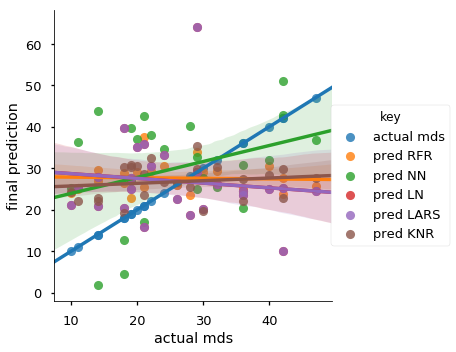

In [7]:
### calculate final predictions without second stack (from first stack only) ###
one_stack_predictions = pd.DataFrame()
for col in list(second_stack_predictions.columns.values)[1:]:
    df = pd.DataFrame()
    df['subj'] = second_stack_predictions['subj']
    df['actual mds'] = second_stack_predictions['actual mds']
    df['final prediction'] = second_stack_predictions[col]
    df['key'] = col
    one_stack_predictions = one_stack_predictions.append(df, ignore_index = True)

sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = one_stack_predictions, order = 1)

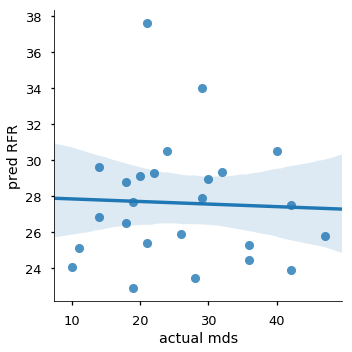

In [8]:
### 1 stack followed by RFR ###
sns.lmplot(x = 'actual mds', y = 'pred RFR', data = second_stack_predictions, order = 1)

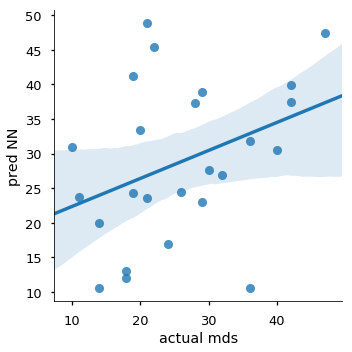

In [18]:
### 1 stack followed by NN ###
sns.lmplot(x = 'actual mds', y = 'pred NN', data = second_stack_predictions, order = 1)

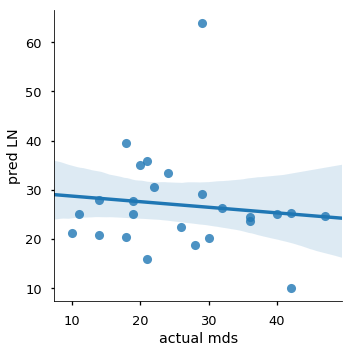

In [10]:
sns.lmplot(x = 'actual mds', y = 'pred LN', data = second_stack_predictions, order = 1)

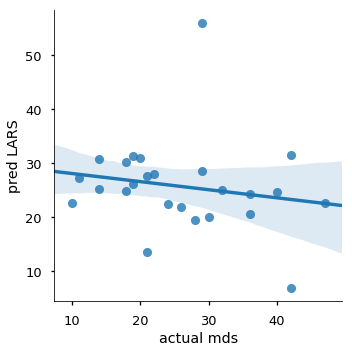

In [19]:
### 1 stack followed by LARS ###
sns.lmplot(x = 'actual mds', y = 'pred LARS', data = second_stack_predictions, order = 1)

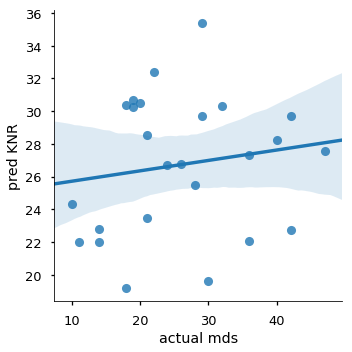

In [12]:
### 1 stack followed by KNR ###
sns.lmplot(x = 'actual mds', y = 'pred KNR', data = second_stack_predictions, order = 1)

In [13]:
### calculate second stack from first stack - WITHOUT USING BASELINE ###
second_stack_predictions_RFR = []
second_stack_predictions_NN = []
second_stack_predictions_LN = []
second_stack_predictions_LARS = []
second_stack_predictions_KNR = []
actual_mds = []
baseline_mds = []
subjs2 = []

clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

for s in stacked_predictions['subj'].unique():
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 3:].values
    stacked_test = stacked_test.iloc[:, 3:].values
    
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        
        subjs2 += [s for elem in list(stacked_ytest)]

second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'baseline mds', value = np.array(baseline_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,0.008693,0.246136,0.145812,0.030920,0.256781,0.256781,-0.153254
actual mds,0.008693,1.000000,0.384480,-0.150600,0.363628,-0.181577,-0.181577,0.024866
baseline mds,0.246136,0.384480,1.000000,-0.388702,0.271010,0.088079,0.088079,-0.037041
pred RFR,0.145812,-0.150600,-0.388702,1.000000,0.309991,0.411964,0.411964,0.270702
pred NN,0.030920,0.363628,0.271010,0.309991,1.000000,0.092209,0.092209,0.567631
pred LN,0.256781,-0.181577,0.088079,0.411964,0.092209,1.000000,1.000000,0.505498
pred LARS,0.256781,-0.181577,0.088079,0.411964,0.092209,1.000000,1.000000,0.505498
pred KNR,-0.153254,0.024866,-0.037041,0.270702,0.567631,0.505498,0.505498,1.000000


In [27]:
### calculate final predictions from second stack ###
actual_mds = []
predictions_final = []
subjs3 = []

#clf_final = RandomForestRegressor(n_estimators=50, random_state = 2) # could change???
#clf_final = MLPRegressor(max_iter = 10000, random_state = 2)
clf_final = LinearRegression()
#clf_final = Lars(eps = 2.220446049250313e-7)
#clf_final = KNeighborsRegressor(weights = 'distance')

for s in second_stack_predictions['subj'].unique():
    second_stack_train = second_stack_predictions[second_stack_predictions.subj != s]
    second_stack_test = second_stack_predictions[second_stack_predictions.subj == s]
    second_stack_ytrain = second_stack_train['actual mds'].values.astype(int)
    second_stack_ytest = second_stack_test['actual mds'].values.astype(int)
    second_stack_train = second_stack_train.iloc[:, 2:].values
    second_stack_test = second_stack_test.iloc[:, 2:].values
    
    scaler = StandardScaler() 
    scaler.fit(second_stack_train)  
    second_stack_std = scaler.transform(second_stack_train)
    second_stack_test_std = scaler.transform(second_stack_test)
    
    clf_final.fit(second_stack_train, second_stack_ytrain)
    
    if (len(second_stack_test) != 0):
        actual_mds += list(second_stack_ytest)
        predictions_final += list(clf_final.predict(second_stack_test))
        subjs3 += [s for elem in list(second_stack_ytest)]

predictions = pd.DataFrame()
predictions.insert(loc = len(predictions.columns.values), column = 'subj', value = np.array(subjs3))
predictions.insert(loc = len(predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
predictions.insert(loc = len(predictions.columns.values), column = 'final prediction', value = np.array(predictions_final))
predictions.corr()

,subj,actual mds,final prediction
subj,1.000000,0.008693,0.223791
actual mds,0.008693,1.000000,0.111929
final prediction,0.223791,0.111929,1.000000


number of data points: 25
correlation coefficient: 0.11192887205204623
RMSE: 11.762995215835778


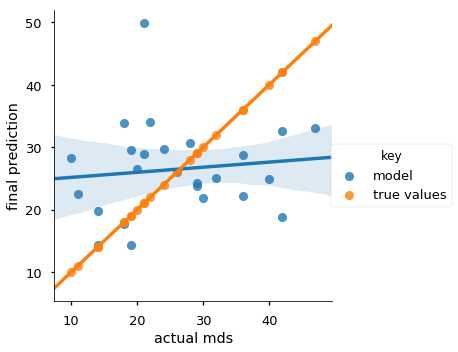

In [28]:
predictions['key'] = 'model'
actual_for_comp = pd.DataFrame()
actual_for_comp['subj'] = predictions['subj']
actual_for_comp['actual mds'] = predictions['actual mds']
actual_for_comp['final prediction'] = predictions['actual mds']
actual_for_comp['key'] = 'true values'

#print('excluding datapoints with the highest and lowest actual MDS scores')
#predictions = predictions[(predictions['actual mds'] > 6) & (predictions['actual mds'] < 30)]
print('number of data points: ' + len(predictions.index.values).__str__())

print('correlation coefficient: ' + np.corrcoef(predictions['final prediction'], predictions['actual mds'])[0][1].__str__())
print('RMSE: ' + float(np.sqrt(np.mean((np.array(predictions['final prediction']) - predictions['actual mds'])**2))).__str__()) 

df_display = predictions.append(actual_for_comp, ignore_index = True)
sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = df_display, order = 1)

In [16]:
# print(len(a))
# i = []
# for item in a:
#     i += ['predicted']
# for item in a:
#     i += ['actual']
# actual = np.array(a)
# predictions = np.array(p)

# error = np.abs(actual - predictions)
# df1 = pd.DataFrame()
# df1.insert(loc = len(df1.columns.values), column = 'actual mds', value = actual)
# df1.insert(loc = len(df1.columns.values), column = 'error', value = error)
# sns.lmplot(x = 'actual mds', y = 'error', data = df1, order = 1)

In [17]:
# mse = float(np.mean((actual - predictions)**2))
# print(mse)

# print(np.corrcoef(p, a)[0][1])
    
# p += a
# a += a
# actual = np.array(a)
# predictions = np.array(p)

# df = pd.DataFrame()
# df.insert(loc = len(df.columns.values), column = 'predicted', value = predictions)
# df.insert(loc = len(df.columns.values), column = 'actual', value = actual)
# df.insert(loc = len(df.columns.values), column = 'hue', value = i)
# sns.lmplot(x = 'actual', y = 'predicted', hue = 'hue', data = df, order = 1)